# Analysis notebook comparing scoping vs no-scoping for tower selection
Purpose of this notebook is to categorize and analyze generated towers.

Requires:
* `.pkl` generated by `stimuli/score_towers.py`

See also:
* `stimuli/generate_towers.ipynb` for plotting code and a similar analysis in the same place as the tower generation code. This notebook supersedes it.

In [169]:
# set up imports
import os
import sys
__file__ = os.getcwd()
proj_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(proj_dir)
utils_dir = os.path.join(proj_dir, 'utils')
sys.path.append(utils_dir)
analysis_dir = os.path.join(proj_dir, 'analysis')
analysis_utils_dir = os.path.join(analysis_dir, 'utils')
sys.path.append(analysis_utils_dir)
agent_dir = os.path.join(proj_dir, 'model')
sys.path.append(agent_dir)
agent_util_dir = os.path.join(agent_dir, 'utils')
sys.path.append(agent_util_dir)
experiments_dir = os.path.join(proj_dir, 'experiments')
sys.path.append(experiments_dir)
df_dir = os.path.join(proj_dir, 'results/dataframes')
stim_dir = os.path.join(proj_dir, 'stimuli')


In [170]:
import tqdm

import pickle

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as stats
from scipy.stats import sem as sem

from scoping_simulations.utils.blockworld_library import *
from scoping_simulations.utils.blockworld import *

from scoping_simulations.model.BFS_Lookahead_Agent import BFS_Lookahead_Agent
from scoping_simulations.model.BFS_Agent import BFS_Agent
from scoping_simulations.model.Astar_Agent import Astar_Agent


In [171]:
# show all columns in dataframe
pd.set_option('display.max_columns', None)


In [172]:
# some helper functions

# look at towers
def visualize_towers(towers, text_parameters=None):
    fig, axes = plt.subplots(math.ceil(len(towers)/5),
                             5, figsize=(20, 15*math.ceil(len(towers)/20)))
    for axis, tower in zip(axes.flatten(), towers):
        axis.imshow(tower['bitmap']*1.0)
        if text_parameters is not None:
            if type(text_parameters) is not list:
                text_parameters = [text_parameters]
            for y_offset, text_parameter in enumerate(text_parameters):
                axis.text(0, y_offset*1., str(text_parameter+": " +
                          str(tower[text_parameter])), color='gray', fontsize=20)
    plt.tight_layout()
    plt.show()


Load in data (we might have multiple dfs)

In [192]:
path_to_dfs = [os.path.join(df_dir, f)
               for f in ["RLDM_main_experiment.pkl"]]
dfs = [pd.read_pickle(path_to_df) for path_to_df in path_to_dfs]
print("Read {} dataframes: {}".format(len(dfs), path_to_dfs))
# merge dfs
df = pd.concat(dfs)
print("Merged dataframes: {}".format(df.shape))


Read 1 dataframes: ['/Users/felixbinder/Cloud/Grad School/Fan Lab/Block Construction/tools_block_construction/results/dataframes/RLDM_main_experiment.pkl']
Merged dataframes: (1508, 51)


In [193]:
# do a few things to add helpful columns and such
# use either solution_cost or states_evaluated as cost
df['cost'] = np.maximum(df['solution_cost'].fillna(0),
                        df['states_evaluated'].fillna(0))
# do the same for total cost
df['total_cost'] = np.maximum(df['all_sequences_planning_cost'].fillna(
    0), df['states_evaluated'].fillna(0))


In [194]:
df.columns


Index(['run_ID', 'agent', 'world', 'step', 'planning_step', 'states_evaluated',
       'action', '_action', 'action_x', 'action_block_width',
       'action_block_height', 'blocks', '_blocks', 'blockmap', '_world',
       'legal_action_space', 'fast_failure', 'execution_time', 'world_status',
       'world_failure_reason', 'agent_attributes', 'agent_type', 'label',
       'decomposition_function', 'number_of_sequences', 'c_weight', 'max_cost',
       'step_size', 'random_seed', 'lower level: agent_type',
       'lower level: heuristic', 'lower level: random_seed',
       'lower level: label', 'decomposition function: necessary_conditions',
       'decomposition function: necessary_sequence_conditions', 'physics',
       'partial_solution_cost', 'solution_cost', 'partial_planning_cost',
       'planning_cost', 'all_sequences_planning_cost', 'decomposed_silhouette',
       '_all_subgoal_sequences', '_chosen_subgoal_sequence', 'heuristic', 'F1',
       'final_row', 'perfect', 'agent_attri

In [197]:
# summarize the runs into a run df
def summarize_df(df):
    summary_df = df.groupby('run_ID').agg({
        'agent': 'first',
        'label': 'first',
        'world': 'first',
        'action': 'count',
        'blockmap': 'last',
        'states_evaluated': ['sum', 'mean', sem],
        'partial_solution_cost': ['sum', 'mean', sem],
        'solution_cost': ['sum', 'mean', sem],
        'all_sequences_planning_cost': ['sum', 'mean', sem],
        'perfect': 'last',
        'cost': ['sum', 'mean', sem],
        'total_cost': ['sum', 'mean', sem],
        # 'avg_cost_per_step_for_run': ['sum', 'mean', sem],
    })
    return summary_df


In [198]:
sum_df = summarize_df(df)


/Users/felixbinder/opt/anaconda3/envs/scoping/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/felixbinder/opt/anaconda3/envs/scoping/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Let's explore the data a little bit

In [199]:
sum_df


agent  \
                                                                      first   
run_ID                                                                        
0 | Best_First_Search_Agent heuristic: F1score ...  Best_First_Search_Agent   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
...                                                                     ...   
9 | Best_First_Search_Agent heuristic: F1score ...  Best_First_Search_Agent   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   Subgoal_Planning_Agent   

                                                                           label  \
                                                                           first   
run_ID                                                                             
0 | Best_First_Search_Agent heuristic: F1score ...                    Best First   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  Full Subgoal Decomposition 2   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  Full Subgoal Decomposition 3   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...           Incremental Scoping   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...             Lookahead Scoping   
...                                                                          ...   
9 | Best_First_Search_Agent heuristic: F1score ...                    Best First   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  Full Subgoal Decomposition 2   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  Full Subgoal Decomposition 3   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...           Incremental Scoping   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...             Lookahead Scoping   

                                                   world action  \
                                                   first  count   
run_ID                                                            
0 | Best_First_Search_Agent heuristic: F1score ...   0.0      9   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   0.0      0   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   0.0      9   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   0.0      9   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   0.0      6   
...                                                  ...    ...   
9 | Best_First_Search_Agent heuristic: F1score ...   9.0      8   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   9.0      0   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   9.0      8   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   9.0      8   
9 | {'agent_type': 'Subgoal_Planning_Agent', 'l...   9.0      8   

                                                                                             blockmap  \
                                                                                                 last   
run_ID                                                                                                  
0 | Best_First_Search_Agent heuristic: F1score ...  [[0, 0, 0, 0, 9, 0, 0, 0], [0, 0, 0, 0, 9, 0, ...   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...                                               None   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  [[0, 0, 0, 0, 4, 0, 0, 0], [0, 0, 0, 0, 4, 0, ...   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  [[0, 0, 0, 0, 9, 0, 0, 0], [0, 0, 0, 0, 9, 0, ...   
0 | {'agent_type': 'Subgoal_Planning_Agent', 'l...  [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...   
...    

In [201]:
sum_df.groupby([('label', 'first')]).mean()


world    action states_evaluated               \
                             first     count              sum         mean   
(label, first)                                                               
Best First                    31.5  7.250000      5392.546875  5392.546875   
Full Subgoal Decomposition 2  31.5  2.859375         0.000000          NaN   
Full Subgoal Decomposition 3  31.5  3.625000         0.000000          NaN   
Incremental Scoping           31.5  4.531250         0.000000          NaN   
Lookahead Scoping             31.5  2.781250         0.000000          NaN   

                                 partial_solution_cost                \
                             sem                   sum      mean sem   
(label, first)                                                         
Best First                   NaN              0.000000       NaN NaN   
Full Subgoal Decomposition 2 NaN              9.593750  9.593750 NaN   
Full Subgoal Decomposition 3 NaN              5.687500  5.687500 NaN   
Incremental Scoping          NaN             10.328125  4.781250 NaN   
Lookahead Scoping            NaN              7.093750  2.175781 NaN   

                             solution_cost                \
                                       sum      mean sem   
(label, first)                                             
Best First                        0.000000       NaN NaN   
Full Subgoal Decomposition 2      9.593750  9.593750 NaN   
Full Subgoal Decomposition 3      5.687500  5.687500 NaN   
Incremental Scoping              10.328125  4.781250 NaN   
Lookahead Scoping                13.281250  3.959635 NaN   

                             all_sequences_planning_cost                    \
                                                     sum          mean sem   
(label, first)                                                               
Best First                                      0.000000           NaN NaN   
Full Subgoal Decomposition 2                  391.234375    391.234375 NaN   
Full Subgoal Decomposition 3                12674.593750  12674.593750 NaN   
Incremental Scoping                          2294.906250   1802.505208 NaN   
Lookahead Scoping                           94212.296875  59062.990885 NaN   

                               perfect         cost                          \
                                  last          sum        mean         sem   
(label, first)                                                                
Best First                    1.000000  5392.546875  620.042721  620.042721   
Full Subgoal Decomposition 2  0.421875     9.593750    1.297197    3.074838   
Full Subgoal Decomposition 3  0.515625     5.687500    0.801736    1.554882   
Incremental Scoping           0.281250    10.328125    1.449758    1.615141   
Lookahead Scoping             0.000000    13.281250    1.765805    2.936308   

                                total_cost                              
                                       sum          mean           sem  
(label, first)                                                          
Best First                     5392.546875    620.042721    620.042721  
Full Subgoal Decomposition 2    391.234375    340.658600     23.820385  
Full Subgoal Decomposition 3  12674.593750   8681.691251   1175.583033  
Incremental Scoping            2294.906250   1489.937085    180.883842  
Lookahead Scoping             94212.296875  50396.992553  13152.121078

In [202]:
sum_df.groupby([('label', 'first')]).count()


agent world action blockmap states_evaluated  \
                             first first  count     last              sum   
(label, first)                                                              
Best First                      64    64     64       64               64   
Full Subgoal Decomposition 2    64    64     64       27               64   
Full Subgoal Decomposition 3    64    64     64       33               64   
Incremental Scoping             64    64     64       44               64   
Lookahead Scoping               64    64     64       30               64   

                                      partial_solution_cost           \
                             mean sem                   sum mean sem   
(label, first)                                                         
Best First                     64   0                    64    0   0   
Full Subgoal Decomposition 2    0   0                    64   64   0   
Full Subgoal Decomposition 3    0   0                    64   64   0   
Incremental Scoping             0   0                    64   64   0   
Lookahead Scoping               0   0                    64   64   0   

                             solution_cost           \
                                       sum mean sem   
(label, first)                                        
Best First                              64    0   0   
Full Subgoal Decomposition 2            64   64   0   
Full Subgoal Decomposition 3            64   64   0   
Incremental Scoping                     64   64   0   
Lookahead Scoping                       64   64   0   

                             all_sequences_planning_cost          perfect  \
                                                     sum mean sem    last   
(label, first)                                                              
Best First                                            64    0   0      64   
Full Subgoal Decomposition 2                          64   64   0      64   
Full Subgoal Decomposition 3                          64   64   0      64   
Incremental Scoping                                   64   64   0      64   
Lookahead Scoping                                     64   64   0      64   

                             cost          total_cost           
                              sum mean sem        sum mean sem  
(label, first)                                                  
Best First                     64   64  64         64   64  64  
Full Subgoal Decomposition 2   64   64  27         64   64  27  
Full Subgoal Decomposition 3   64   64  33         64   64  33  
Incremental Scoping            64   64  44         64   64  44  
Lookahead Scoping              64   64  30         64   64  30

What is the rate of success?

(label, first)
Best First                      1.000000
Full Subgoal Decomposition 2    0.421875
Full Subgoal Decomposition 3    0.515625
Incremental Scoping             0.281250
Lookahead Scoping               0.000000
Name: (perfect, last), dtype: float64

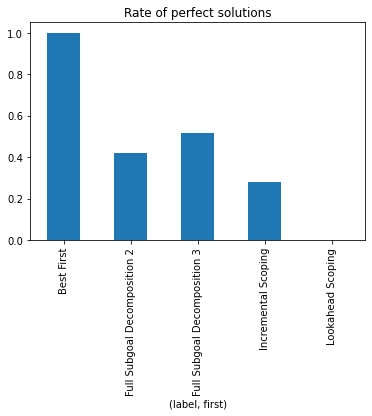

In [203]:
display(sum_df.groupby([('label', 'first')]).mean()[('perfect', 'last')])
sum_df.groupby([('label', 'first')]).mean()[('perfect', 'last')].plot(
    kind='bar', title='Rate of perfect solutions')
plt.show()


What is the difference in cost between the two conditions?

(label, first)
Best First                      5392.546875
Full Subgoal Decomposition 2       9.593750
Full Subgoal Decomposition 3       5.687500
Incremental Scoping               10.328125
Lookahead Scoping                 13.281250
Name: (cost, sum), dtype: float64

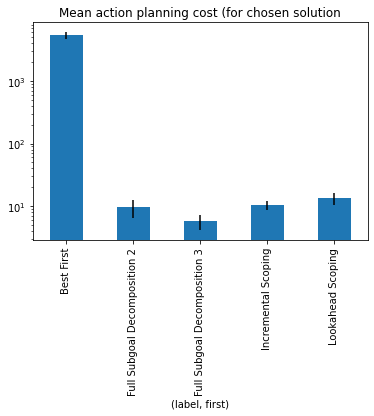

In [205]:
display(sum_df.groupby([('label', 'first')]).mean()[('cost', 'sum')])
sum_df.groupby([('label', 'first')]).mean()[('cost', 'sum')].plot(
    kind='bar', title='Mean action planning cost (for chosen solution', yerr=sum_df.groupby([('label', 'first')]).mean()[('cost', 'sem')])
plt.yscale('log')
plt.show()


What about the total cost?

(label, first)
Best First                       5392.546875
Full Subgoal Decomposition 2      391.234375
Full Subgoal Decomposition 3    12674.593750
Incremental Scoping              2294.906250
Lookahead Scoping               94212.296875
Name: (total_cost, sum), dtype: float64

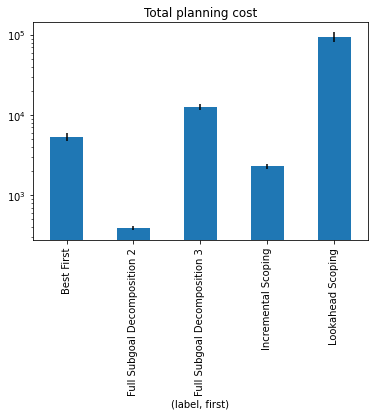

In [208]:
display(sum_df.groupby([('label', 'first')]).mean()[('total_cost', 'sum')])
sum_df.groupby([('label', 'first')]).mean()[('total_cost', 'sum')].plot(
    kind='bar', title='Total planning cost', yerr=sum_df.groupby([('label', 'first')]).mean()[('total_cost', 'sem')])
plt.yscale('log')
plt.show()


In [214]:
df[df['label'] == 'Full Subgoal Decomposition 2']['_world'].tail(1).item().silhouette

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.]])

Is there a difference between the depth of found solutions?

(label, first)
Best First                      7.250000
Full Subgoal Decomposition 2    2.859375
Full Subgoal Decomposition 3    3.625000
Incremental Scoping             4.531250
Lookahead Scoping               2.781250
Name: (action, count), dtype: float64

<AxesSubplot:title={'center':'Mean number of actions'}, xlabel='(label, first)'>

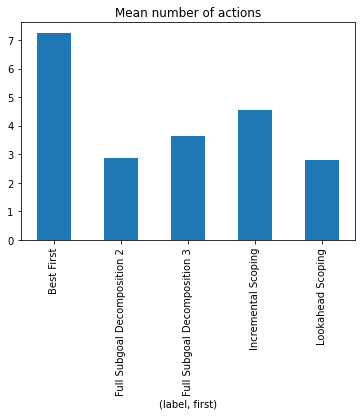

In [209]:
display(sum_df.groupby([('label', 'first')]).mean()[('action', 'count')])
sum_df.groupby([('label', 'first')]).mean()[('action', 'count')
                                            ].plot(kind='bar', title='Mean number of actions')


## Tower analysis
Now that we have explored the data, let's look at the distribution over towers.

Let's make a scatterplot over subgoal and no subgoal costs.

In [188]:
tower_sum_df = df.groupby(['label', 'world']).agg({
    'cost': ['sum', 'mean', sem],
    'total_cost': ['sum', 'mean', sem],
})
# flatten the index
tower_sum_df.reset_index(inplace=True)


In [189]:
tower_sum_df


label world   cost                         total_cost  \
                                       sum        mean         sem        sum   
0                  Best First   0.0   21.0    2.333333    2.333333       21.0   
1                  Best First   1.0  108.0   12.000000   12.000000      108.0   
2                  Best First   2.0  804.0  100.500000  100.500000      804.0   
3  Full Subgoal Decomposition   0.0    0.0    0.000000    0.000000    12453.0   
4         Incremental Scoping   0.0    0.0    0.000000    0.000000        0.0   
5         Incremental Scoping   1.0    0.0    0.000000    0.000000        0.0   
6           Lookahead Scoping   0.0   14.0    2.333333    2.333333    71508.0   

                               
           mean           sem  
0      2.333333      2.333333  
1     12.000000     12.000000  
2    100.500000    100.500000  
3   4151.000000   4151.000000  
4      0.000000      0.000000  
5      0.000000      0.000000  
6  11918.000000  11918.000000

In [190]:
# for the scatterplots, we can only show two agents at the same time.
label1 = 'Full Subgoal Planning'
label2 = 'Best First Search'


In [191]:
plt.scatter(
    x=tower_sum_df[tower_sum_df['label'] == label1]['cost']['sum'],
    y=tower_sum_df[tower_sum_df['label'] == label2]['cost']['sum'],
    c=tower_sum_df[tower_sum_df['label'] == label1]['world'])
plt.title("Action planning cost of solving a tower with and without subgoals")
plt.xlabel("Cost of solving without subgoals")
plt.ylabel("Cost of solving with subgoals")
# log log
plt.xscale('log')
plt.yscale('log')
plt.show()


ValueError: Data has no positive values, and therefore can not be log-scaled.

The same for the total subgoal planning cost

ValueError: x and y must be the same size

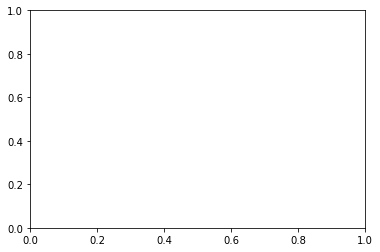

In [ ]:
plt.scatter(
    x=tower_sum_df[tower_sum_df['label'] == label1]['total_cost']['sum'],
    y=tower_sum_df[tower_sum_df['label'] == label2]['total_cost']['sum'],
    c=tower_sum_df[tower_sum_df['label'] == label1]['world'])
plt.title("Action planning cost of solving a tower with and without subgoals")
plt.xlabel("Cost of solving without subgoals")
plt.ylabel("Cost of solving with subgoals")
# log log
plt.xscale('log')
plt.yscale('log')
plt.show()


Can we see a pattern between the relation of the solution and total subgoal planning cost for the subgoal agent?

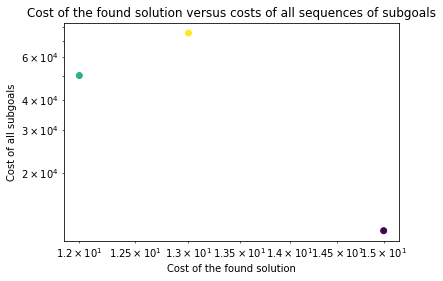

In [ ]:
plt.scatter(
    x=tower_sum_df[tower_sum_df['label'] == label1]['cost']['sum'],
    y=tower_sum_df[tower_sum_df['label'] == label2]['total_cost']['sum'],
    c=tower_sum_df[tower_sum_df['label'] == label1]['world'])
plt.title("Cost of the found solution versus costs of all sequences of subgoals")
plt.xlabel("Cost of the found solution")
plt.ylabel("Cost of all subgoals")
# log log
plt.xscale('log')
plt.yscale('log')
plt.show()


Looks like there are some **outliers**—let's look at those

Do we have towers that can't be solved using a subgoal decomposition?

In [ ]:
failed_df = df[(df['perfect'] == False)]
display(failed_df)


,run_ID,agent,world,step,planning_step,states_evaluated,action,_action,action_x,action_block_width,action_block_height,blocks,_blocks,blockmap,_world,legal_action_space,fast_failure,execution_time,world_status,world_failure_reason,agent_attributes,agent_type,sequence_length,decomposition_function,include_subsequences,number_of_sequences,c_weight,max_cost,step_size,random_seed,lower level: agent_type,lower level: heuristic,lower level: random_seed,partial_solution_cost,solution_cost,partial_planning_cost,planning_cost,all_sequences_planning_cost,decomposed_silhouette,_all_subgoal_sequences,_chosen_subgoal_sequence,heuristic,F1,final_row,perfect,agent_attributes_string,avg_cost_per_step_for_run,agent_label,cost,total_cost
71,0 | Best_First_Search_Agent heuristic: F1score...,Best_First_Search_Agent,0.0,0.0,1.0,NaN,"[(1x3), 3]","((1x3), 3)",3.0,1.0,3.0,"[1x3 at (3,7)]","[1x3 at (3,7)]","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",Blockworld,1.0,0.0,NaN,NaN,NaN,"{'agent_type': 'Best_First_Search_Agent', 'heu...",Best_First_Search_Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1score,0.230769,False,False,"{'agent_type': 'Best_First_Search_Agent', 'heu...",NaN,Best_First_Search_Agent,0.0,0.0
72,0 | Best_First_Search_Agent heuristic: F1score...,Best_First_Search_Agent,0.0,1.0,1.0,NaN,"[(1x3), 3]","((1x3), 3)",3.0,1.0,3.0,"[1x3 at (3,7), 1x3 at (3,4)]","[1x3 at (3,7), 1x3 at (3,4)]","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",Blockworld,1.0,0.0,NaN,NaN,NaN,"{'agent_type': 'Best_First_Search_Agent', 'heu...",Best_First_Search_Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1score,0.413793,False,False,"{'agent_type': 'Best_First_Search_Agent', 'heu...",NaN,Best_First_Search_Agent,0.0,0.0
73,0 | Best_First_Search_Agent heuristic: F1score...,Best_First_Search_Agent,0.0,2.0,1.0,NaN,"[(1x3), 5]","((1x3), 5)",5.0,1.0,3.0,"[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7)]","[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7)]","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",Blockworld,1.0,0.0,NaN,NaN,NaN,"{'agent_type': 'Best_First_Search_Agent', 'heu...",Best_First_Search_Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1score,0.562500,False,False,"{'agent_type': 'Best_First_Search_Agent', 'heu...",NaN,Best_First_Search_Agent,0.0,0.0
74,0 | Best_First_Search_Agent heuristic: F1score...,Best_First_Search_Agent,0.0,3.0,1.0,NaN,"[(1x3), 2]","((1x3), 2)",2.0,1.0,3.0,"[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7), 1x3...","[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7), 1x3...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",Blockworld,1.0,0.0,NaN,NaN,NaN,"{'agent_type': 'Best_First_Search_Agent', 'heu...",Best_First_Search_Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1score,0.685714,False,False,"{'agent_type': 'Best_First_Search_Agent', 'heu...",NaN,Best_First_Search_Agent,0.0,0.0
75,0 | Best_First_Search_Agent heuristic: F1score...,Best_First_Search_Agent,0.0,4.0,1.0,NaN,"[(1x3), 4]","((1x3), 4)",4.0,1.0,3.0,"[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7), 1x3...","[1x3 at (3,7), 1x3 at (3,4), 1x3 at (5,7), 1x3...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...",Blockworld,1.0,0.0,NaN,NaN,NaN,"{'agent_type': 'Best_First_Search_Agent', 'heu...",Best_First_Search_Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F1score,0.789474,False,False,"{'agent_type': 'Best_First_Search_Agent', 'heu...",NaN,Best_First_Search_Agent,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,"14 | {'agent_type': 'Subgoal_Planning_Agent', ...",Subgoal_Planning_Agent,14.0,3.0,1.0,NaN,"[(1x2), 2]","((1x2), 2)",2.0,1.0,2.0,"[1x3 at (5,7), 1x3 at (5,4), 1x3 at (2,7), 1x2...","[1x3 at (5,7), 1x3 at (5,4), 1x3 at (2,7), 1x2...","[[0, 0, 0, 0,

In [ ]:
bad_ID = list(df[df['world_status'] == 'Fail']['run_ID'])[1]


IndexError: list index out of range

In [ ]:
bad_ID


NameError: name 'bad_ID' is not defined

In [ ]:
df[df['run_ID'] == bad_ID]


NameError: name 'bad_ID' is not defined

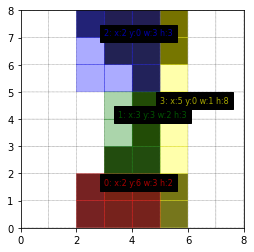

In [ ]:
df[df['run_ID'] == bad_ID]['_chosen_subgoal_sequence'].dropna(
).values[-1].visual_display()


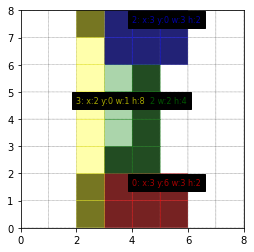

In [ ]:
df[df['run_ID'] == bad_ID]['_chosen_subgoal_sequence'].dropna(
).values[0][0].visual_display()


In [ ]:
failed_df['_world'].tail(1).item().silhouette


array([[0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.]])

In [ ]:
failed_df['_world'].head(1).item().silhouette


array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0.]])